# Ensemble modeling 
+ Study ensemble model with titanic data from kaggle
+ Source : "https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/data"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 1. Load data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Variable 설명

+ PassengerId : ID
+ Survived : Survival (0 = No, 1 = Yes; only in train set)
+ Pclass : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
+ Name : name 
+ Sex : sex
+ Age : age
+ SibSp : number of siblings or spouses aboard the Titanic
+ Parch : number of parents or children aboard the Titanic
+ Ticket : ticket number
+ Fare : passenger fare
+ Cabin : Cabin number
+ embarked : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare (numeric variable) 
# 4개의 변수 중 outlier를 2개 이상 가진 관측치를 outlier로 보고 제거
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"]) 

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [5]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [7]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
print(train_len) 
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

881


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


### check for null and missing values 

In [8]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)
dataset.info()

# Check for Null values in dataset
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

,Total,Percent
Cabin,1007,0.775212
Survived,418,0.321786
Age,256,0.197075
Embarked,2,0.001540
Fare,1,0.000770


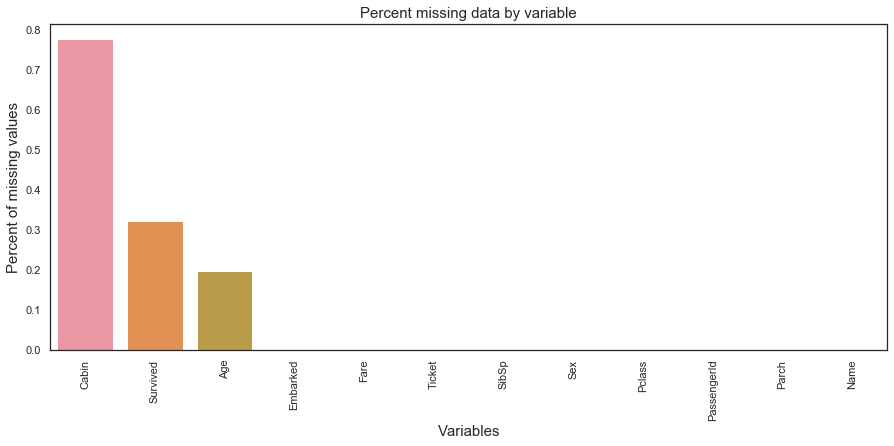

In [9]:
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Variables', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by variable', fontsize=15)
missing_data.head()

In [10]:
# Check for Null values in train dataset
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
# change type of PassengerId from integer to object
train["PassengerId"] = train["PassengerId"].astype(object)
# train["PassengerId"] = train.PassengerId.astype(float)
train.dtypes

PassengerId     object
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
### Summarize data
# Summarie and statistics
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Exploratory data analysis of train data
+ Numeric variables
+ Categorical variables

### Numeric variables

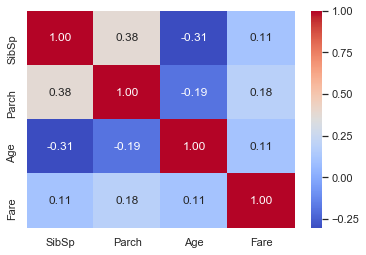

In [13]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values)
g = sns.heatmap(train[["SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


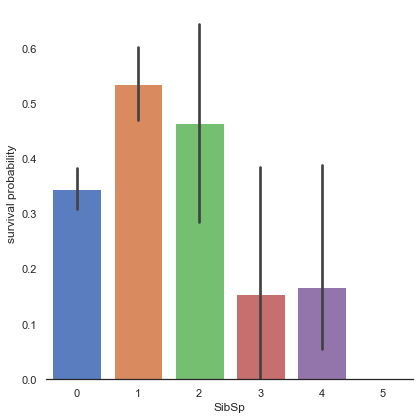

In [14]:
# Explore SibSp vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train, kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


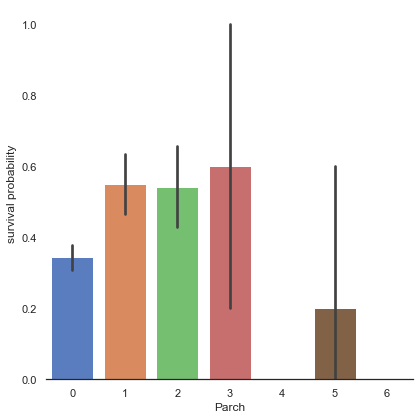

In [15]:
# Explore Parch vs Survived
g2 = sns.factorplot(x="Parch",y="Survived",data=train, kind="bar", size = 6 , palette = "muted")
g2.despine(left=True)
g2 = g2.set_ylabels("survival probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


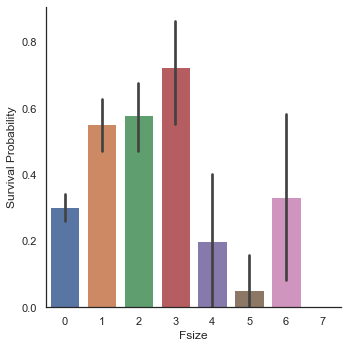

In [16]:
# Create a family size (without self) descriptor from SibSp and Parch
train["Fsize"] = train["SibSp"] + train["Parch"]
test["Fsize"] = test["SibSp"] + test["Parch"]
g3 = sns.factorplot(x="Fsize",y="Survived", kind="bar", data = train)
g3 = g3.set_ylabels("Survival Probability")

+ 함께 한 가족이 많을 때보다 적을 때 생존율이 높다.
+ 가족이 많을수록 생존율의 편차가 커지는 것을 볼 수 있다.
+ 혼자 배를 탄 경우보다는 동승한 가족이 1~3명일 때 오히려 생존율이 높다는 점을 주목해볼 수 있다.
  (혼자 탑승한 승객이 가지고 있는 특성을 분석해볼 필요 있음) 


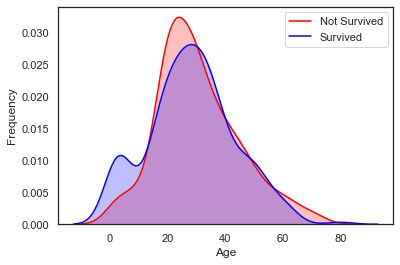

In [17]:
# Explore Age distibution 
g5 = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g5 = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g5, color="Blue", shade= True)
g5.set_xlabel("Age")
g5.set_ylabel("Frequency")
g5 = g5.legend(["Not Survived","Survived"])

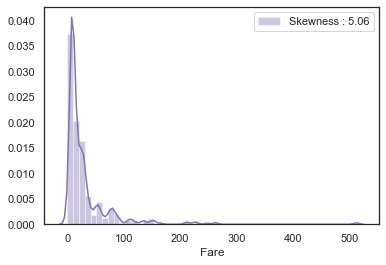

In [18]:
# Explore Fare distribution 
g = sns.distplot(train["Fare"], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
g = g.legend(loc="best")

### Categorical variables

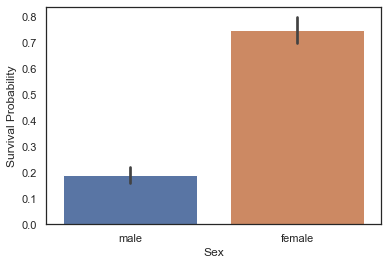

In [19]:
# Explore Sex vs Survived
g6 = sns.barplot(x="Sex",y="Survived",data=train)
g6 = g6.set_ylabel("Survival Probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


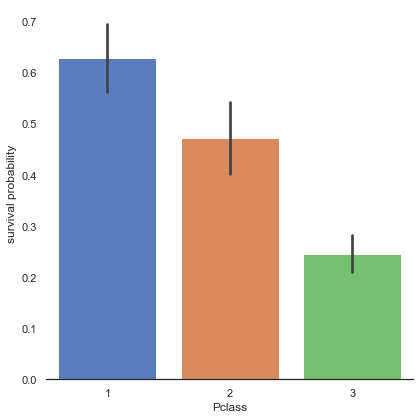

In [20]:
# Explore Pclass vs Survived
g7 = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g7.despine(left=True)
g7 = g7.set_ylabels("survival probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


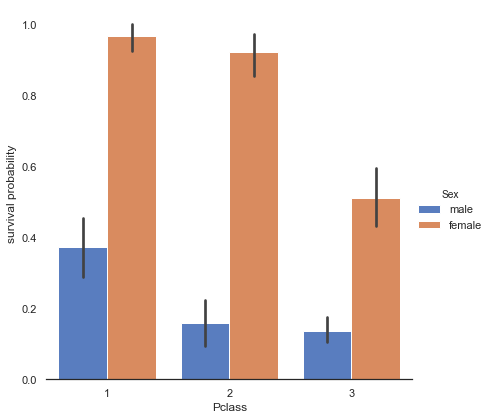

In [21]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


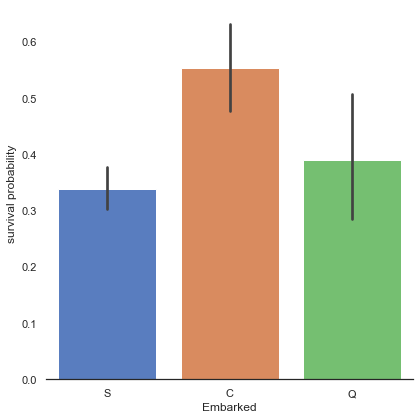

In [22]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


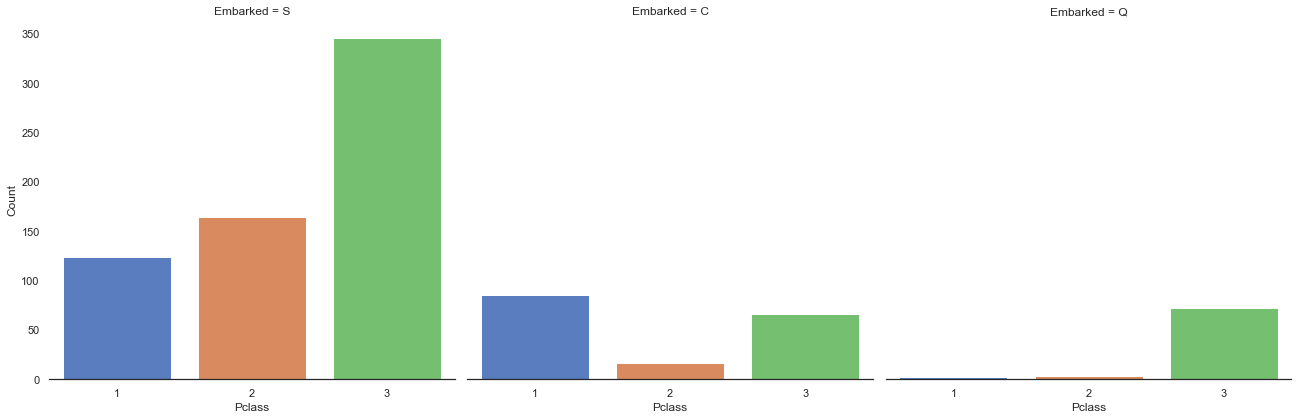

In [23]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


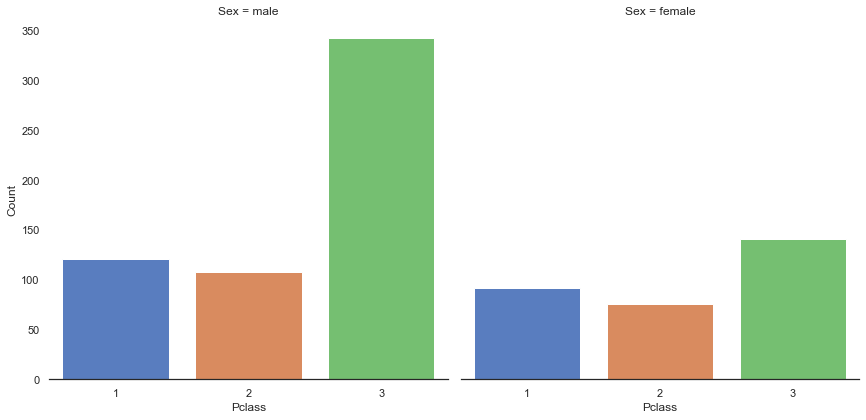

In [24]:
# Explore Pclass vs Sex 
g = sns.factorplot("Pclass", col="Sex",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

+ 1등석과 2등석은 성비가 비슷한데 비해, 3등석은 남성이 훨씬 많다. 
+ 남성과 여성의 생존율 차이가 큰 것은 여성과 어린 아이를 먼저 구한다는 의식과 더불어 생존율이 낮은 3등석에 여자보다 남자가 더 많았기 때문으로 추정된다. 

### 혼자 탑승한 승객이 가지고 있는 특성 분석

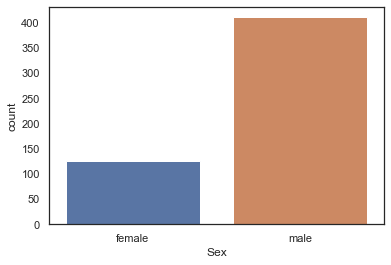

In [25]:
g1 = sns.countplot(x="Sex", data = train[train["Fsize"] == 0])

+ 혼자 탑승한 사람 중에 많은 사람이 남자임을 알 수 있다.

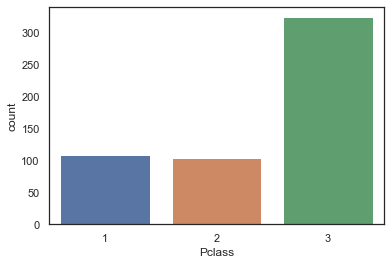

In [26]:
g2 = sns.countplot(x="Pclass", data = train[train["Fsize"] == 0])

+ 혼자 탑승한 사람 중에 많은 사람이 3등석에 탑승했음을 알 수 있다.

## 4. Impute missing data

+ dataset의 missing value를 채우기 위해 몇개의 데이터가 결측이 되어있는지 다시 확인. 
+ 이때 train의 결측치와 test의 결측치는 분리해서 채워야 한다. (data leakage 방지를 위해)
+ Data leakage is when information from outside the training dataset is used to create the model. 
(Source : "https://machinelearningmastery.com/data-leakage-machine-learning/") 
+ test 데이터에서 Survived 변수는 예측을 위해 비어있는 것으로 결측을 채울 필요 없다.

### Check for Null values in train set

In [27]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
Fsize            0
dtype: int64

### 4.1 Embarked variable in train data
위와 같이 변수에서의 결측이 전체 obs 대비 작은 변수는 연속형 변수일 때는 mean/median, 범주형 변수일 때는 가장 빈도가 높은 것으로 채운다. 
Embarked는 범주형 변수이기 때문에 가장 빈도수가 높은 "S"로 채운다. 

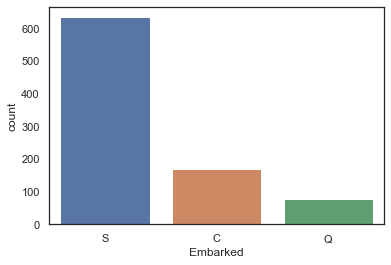

In [28]:
g2 = sns.countplot(x="Embarked", data = train)

#Fill Embarked nan values of dataset set with 'S' most frequent value
train["Embarked"] = train["Embarked"].fillna("S")

### 4.2 Age in train data
Age는 결측치가 170개로 많기 때문에 age와 관련된 변수들을 이용해서 age를 예측해 missing value를 채우는 것이 필요하다. 

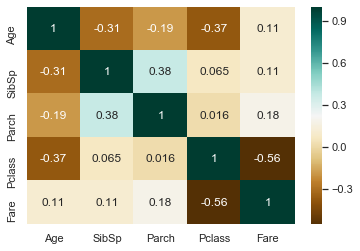

In [29]:
g = sns.heatmap(train[["Age","SibSp","Parch","Pclass","Fare"]].corr(),cmap="BrBG",annot=True)

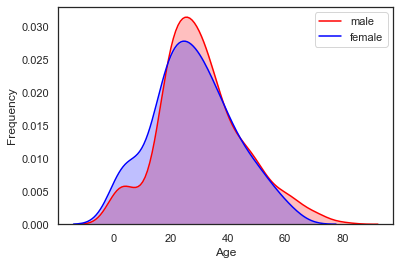

In [30]:
# Explore Age vs Sex 
g5 = sns.kdeplot(train["Age"][(train["Sex"] == "male") & (train["Age"].notnull())], color="Red", shade = True)
g5 = sns.kdeplot(train["Age"][(train["Sex"] == "female") & (train["Age"].notnull())], ax =g5, color="Blue", shade= True)
g5.set_xlabel("Age")
g5.set_ylabel("Frequency")
g5 = g5.legend(["male","female"])

+ correlation plot을 보면 Age는 SibSp, Parch, Pclass, Fare와 어느정도 연관이 있다. 
+ 이와 달리 distribution plot을 보면 Age는 Sex와는 큰 연관이 없다. 
+ 따라서, SibSp, Parch, Pclass, Fare가 비슷한 관측치들의 median age를 구해서 그것을 대체 값으로 사용하기로 한다. 

In [31]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch, SibSp and Fare
# Index of NaN age rows
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][((train['SibSp'] == train.iloc[i]["SibSp"]) & (train['Parch'] == train.iloc[i]["Parch"]) & (train['Pclass'] == train.iloc[i]["Pclass"])& (train['Fare'] == train.iloc[i]["Fare"]))].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med
        
train.isnull().sum()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         0
Fsize            0
dtype: int64

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


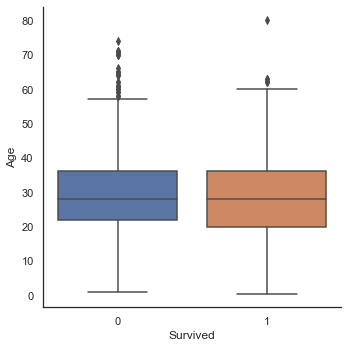

In [32]:
g = sns.factorplot(x="Survived", y = "Age", data = train, kind="box")

### Check for Null values in test set

In [33]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Fsize            0
dtype: int64

### 4.3 Fare variable in test data
연속형 변수일 때는 mean/median으로 채운다. 이때, Fare는 skewness가 크기 때문에 median으로 채우는 것이 적절하다. 

In [34]:
#Fill Fare missing values with the median value
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

### 4.4 Age in test data
Age는 결측치가 86개로 많기 때문에 age와 관련된 변수들을 이용해서 age를 예측해 missing value를 채우는 것이 필요하다. 

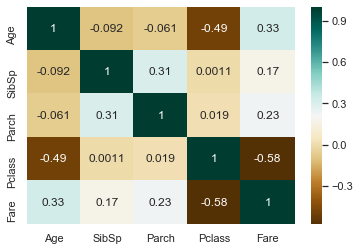

In [35]:
g = sns.heatmap(test[["Age","SibSp","Parch","Pclass","Fare"]].corr(),cmap="BrBG",annot=True)

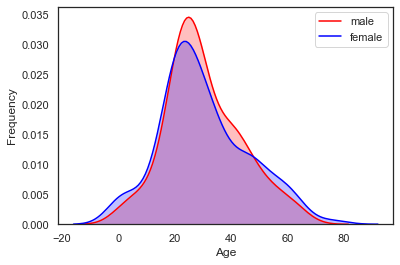

In [36]:
# Explore Age vs Sex 
g5 = sns.kdeplot(test["Age"][(test["Sex"] == "male") & (test["Age"].notnull())], color="Red", shade = True)
g5 = sns.kdeplot(test["Age"][(test["Sex"] == "female") & (test["Age"].notnull())], ax =g5, color="Blue", shade= True)
g5.set_xlabel("Age")
g5.set_ylabel("Frequency")
g5 = g5.legend(["male","female"])

+ correlation plot을 보면 Age는 SibSp, Parch, Pclass, Fare와 어느정도 연관이 있다. 
+ 이와 달리 distribution plot을 보면 Age는 Sex와는 큰 연관이 없다. 
+ 따라서 train set에서와 같이, SibSp, Parch, Pclass, Fare가 비슷한 관측치들의 median age를 구해서 그것을 대체 값으로 사용하기로 한다. 

In [37]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch, SibSp and Fare
# Index of NaN age rows
index_NaN_age = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = test["Age"].median()
    age_pred = test["Age"][((test['SibSp'] == test.iloc[i]["SibSp"]) & (test['Parch'] == test.iloc[i]["Parch"]) & (test['Pclass'] == test.iloc[i]["Pclass"])& (test['Fare'] == test.iloc[i]["Fare"]))].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med
        
test.isnull().sum()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Fsize            0
dtype: int64

### 4.4 Cabin in train/test data
Cabin 변수는 결측치가 전체 데이터의 77%이므로 새로운 값으로 예측해 대체하기 보다는
범주형 변수이기 때문에 결측된 값은 X라는 새로운 카테고리를 생성하고 기존의 값도 A-T까지의 cabin 앞자리로 대체한다. 

In [38]:
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train['Cabin'] ])
test["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test['Cabin'] ])

### 4.5 Ticket in train/test data
Ticket 변수를 다루기 위해서는 변수에 대한 깊은 이해를 기반으로 변수를 변환해야하므로 여기서는 다루지 않도록 한다.  

In [39]:
del train["Ticket"]
del test["Ticket"]

In [40]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset.isnull().sum()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Age              0
Cabin            0
Embarked         0
Fare             0
Fsize            0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
dtype: int64

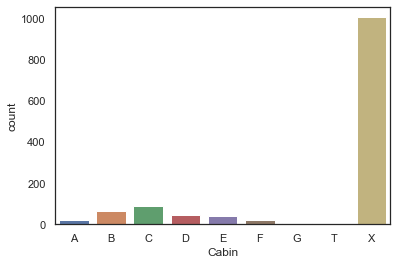

In [41]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


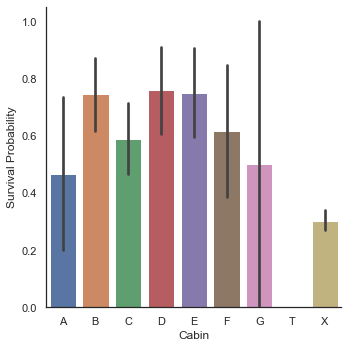

In [42]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

## 5. Ensemble Modeling
Ensemble이란 어느정도 독립적인 여러 모델을 만들고 그것을 통합해 최종적인 결과를 내는 알고리즘으로 대표적인 4가지 방법이 있다.
+ Bagging
+ Boosting
+ Random Forest
+ Stacking

다양한 모형의 결과를 종합하는 방법에는 아래와 같은 세가지 방법이 있다. 
+ Averaging
+ Weighted averaging
+ Majority voting

위의 두가지 방법은 regression에 주로 사용하고 마지막 voting 방법은 classification에 사용한다. 

In [45]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [48]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

ValueError: could not convert string to float: 'Q'

In [50]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'Sheerlinck, Mr. Jan Baptist'